XGBoost - Erro Médio: 14.135145492265393
XGBoost - Erro Mínimo: 0.4523489466035451
XGBoost - Erro Máximo: 153.83651152531147
XGBoost - Desvio Padrão: 20.435450646389402


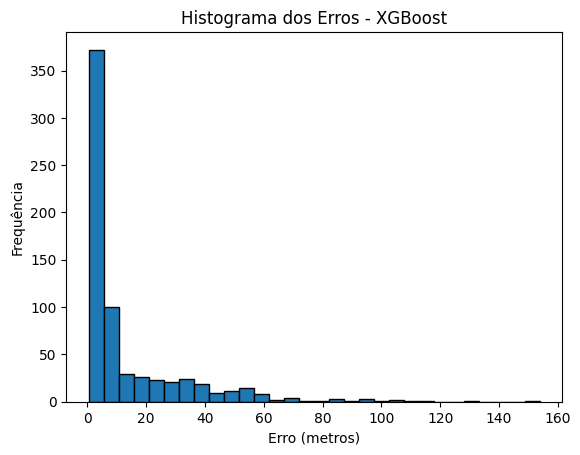

/tmp/ipykernel_11041/2714181703.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_xgb, vert=True, labels=["XGBoost"])


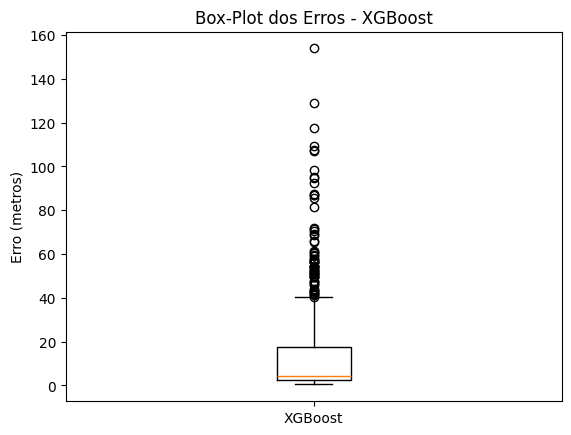

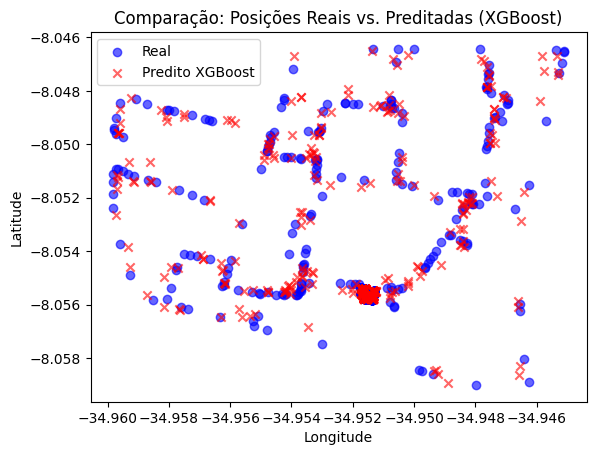

Arquivo de submissão gerado: Resultados_EquipeX_MetodoXGB.csv


In [8]:
# 1. Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import math

# 2. Função para calcular a distância entre dois pontos geográficos (fórmula de Haversine)
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula a distância em metros entre dois pontos definidos por latitude e longitude.
    """
    # Conversão de graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371000  # Raio da Terra em metros
    return c * r

# 3. Leitura dos dados
train_df = pd.read_csv('meds_train_alunos.csv')
test_df = pd.read_csv('meds_test_alunos.csv')
# bts_df = pd.read_csv('Bts.csv')  # Pode ser utilizado para análises adicionais, se necessário

# 4. Pré-processamento e definição das features
features = ['rssi_1_1', 'rssi_1_2', 'rssi_1_3',
            'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
            'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
            'delay_1', 'delay_2', 'delay_3']

X = train_df[features]
y = train_df[['lat', 'lon']]

# 5. Divisão da base de treinamento em treino e validação (10% para validação)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# 6. Treinamento do modelo XGBoost com MultiOutputRegressor
# O XGBRegressor não suporta nativamente multi-target, então utilizamos o MultiOutputRegressor para treinar um modelo para cada alvo.
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train, y_train)

# 7. Realizando predições na base de validação
pred_xgb = multi_xgb.predict(X_val)

# Cálculo dos erros de localização (usando a fórmula de Haversine)
errors_xgb = []
for i in range(len(y_val)):
    actual_lat, actual_lon = y_val.iloc[i]
    pred_lat, pred_lon = pred_xgb[i]
    error = haversine(actual_lat, actual_lon, pred_lat, pred_lon)
    errors_xgb.append(error)

# Impressão das métricas dos erros
print("XGBoost - Erro Médio:", np.mean(errors_xgb))
print("XGBoost - Erro Mínimo:", np.min(errors_xgb))
print("XGBoost - Erro Máximo:", np.max(errors_xgb))
print("XGBoost - Desvio Padrão:", np.std(errors_xgb))

# 8. Visualizações dos resultados
# Histograma dos erros para o XGBoost
plt.figure()
plt.hist(errors_xgb, bins=30, edgecolor='black')
plt.title("Histograma dos Erros - XGBoost")
plt.xlabel("Erro (metros)")
plt.ylabel("Frequência")
plt.show()

# Box-plot dos erros
plt.figure()
plt.boxplot(errors_xgb, vert=True, labels=["XGBoost"])
plt.title("Box-Plot dos Erros - XGBoost")
plt.ylabel("Erro (metros)")
plt.show()

# Scatter plot: Comparação entre posições reais e preditas (usando XGBoost)
plt.figure()
plt.scatter(y_val['lon'], y_val['lat'], color='blue', label='Real', alpha=0.6)
plt.scatter(pred_xgb[:,1], pred_xgb[:,0], color='red', marker='x', label='Predito XGBoost', alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparação: Posições Reais vs. Preditadas (XGBoost)")
plt.legend()
plt.show()

# 9. Predição na base de teste e geração do arquivo de submissão
X_test = test_df[features]
pred_test = multi_xgb.predict(X_test)

# Criação do DataFrame para submissão (conforme submit_alunos.csv: ponto_id, lat, lon)
submit_df = pd.DataFrame({
    'ponto_id': test_df['ponto_id'],
    'lat': pred_test[:, 0],
    'lon': pred_test[:, 1]
})

# Salvando o arquivo de resultados (nome conforme o template, por exemplo: Resultados_EquipeX_MetodoXGB.csv)
submit_df.to_csv("Resultados_EquipeX_MetodoXGB.csv", index=False)
print("Arquivo de submissão gerado: Resultados_EquipeX_MetodoXGB.csv")
